# Traffic Flow Data Warehouse - Exploratory Data Analysis

This notebook performs in-depth exploratory data analysis (EDA) on the traffic flow data to inform data cleaning and transformation decisions for our data warehouse.

## Table of Contents
1. [Setup and Data Loading](#1-setup-and-data-loading)
2. [Data Overview and Initial Profiling](#2-data-overview-and-initial-profiling)
3. [Traffic Measurements Analysis (Fact Table)](#3-traffic-measurements-analysis-fact-table)
4. [Location Dimension Analysis](#4-location-dimension-analysis)
5. [Time Dimension Analysis](#5-time-dimension-analysis)
6. [Weather Dimension Analysis](#6-weather-dimension-analysis)
7. [Event Dimension Analysis](#7-event-dimension-analysis)
8. [Vehicle Dimension Analysis](#8-vehicle-dimension-analysis)
9. [Infrastructure Dimension Analysis](#9-infrastructure-dimension-analysis)
10. [Relationships Between Dimensions](#10-relationships-between-dimensions)
11. [Data Quality Assessment](#11-data-quality-assessment)
12. [Transformation Recommendations](#12-transformation-recommendations)


## 1. Setup and Data Loading

First, we'll import the necessary libraries and load our data from the Excel file.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Visualization settings
plt.style.use('ggplot')
%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# To enable interactive plots with Plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [8]:
# Define path to Excel file
excel_file_path = '../data/traffic_flow_data.xlsx'

# Load data from different sheets
traffic_data = pd.read_excel(excel_file_path, sheet_name='TrafficFlow')
weather_data = pd.read_excel(excel_file_path, sheet_name='WeatherData')
vehicle_data = pd.read_excel(excel_file_path, sheet_name='Vehicles')

# Standardize column names by converting to lowercase and replacing spaces with underscores
for df in [traffic_data, weather_data, vehicle_data]:
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]

## 2. Data Overview and Initial Profiling

Let's get a high-level overview of each dataset.

In [9]:
# Function to print dataset information
def dataset_overview(df, name):
    print(f"\n=== {name} Dataset Overview ===\n")
    print(f"Shape: {df.shape}")
    print(f"\nColumns: {list(df.columns)}")
    print(f"\nData Types:\n{df.dtypes}")
    print(f"\nFirst 5 rows:\n{df.head()}")
    print(f"\nMissing Values:\n{df.isnull().sum()}")
    print(f"\nBasic Statistics:\n{df.describe().T}")
    
# Call the function for each dataset
dataset_overview(traffic_data, "Traffic Measurements")
dataset_overview(weather_data, "Weather")
dataset_overview(vehicle_data, "Vehicles")



=== Traffic Measurements Dataset Overview ===

Shape: (150, 4)

Columns: ['flowid', 'location', 'vehiclecount', 'timestamp']

Data Types:
flowid                   int64
location                object
vehiclecount             int64
timestamp       datetime64[ns]
dtype: object

First 5 rows:
   flowid        location  vehiclecount           timestamp
0       1   Steven Divide           418 2025-02-15 22:08:31
1       2    Walton Manor           992 2025-02-05 18:12:09
2       3    Aaron Harbor           793 2025-02-17 07:56:45
3       4  Johnson Forest           804 2025-02-28 05:24:57
4       5     Mary Bridge           190 2025-02-26 03:51:13

Missing Values:
flowid          0
location        0
vehiclecount    0
timestamp       0
dtype: int64

Basic Statistics:
              count                           mean                  min  \
flowid        150.0                           75.5                  1.0   
vehiclecount  150.0                         534.58                 57.0   
ti

## 3. Traffic Measurements Analysis (Fact Table)

Let's explore the traffic measurements data in detail. This is our fact table containing the key metrics.

In [10]:
# Convert timestamp to datetime if needed
if 'measurement_timestamp' in traffic_data.columns and not pd.api.types.is_datetime64_any_dtype(traffic_data['measurement_timestamp']):
    traffic_data['measurement_timestamp'] = pd.to_datetime(traffic_data['measurement_timestamp'])

KeyError: 'vehicle_count'

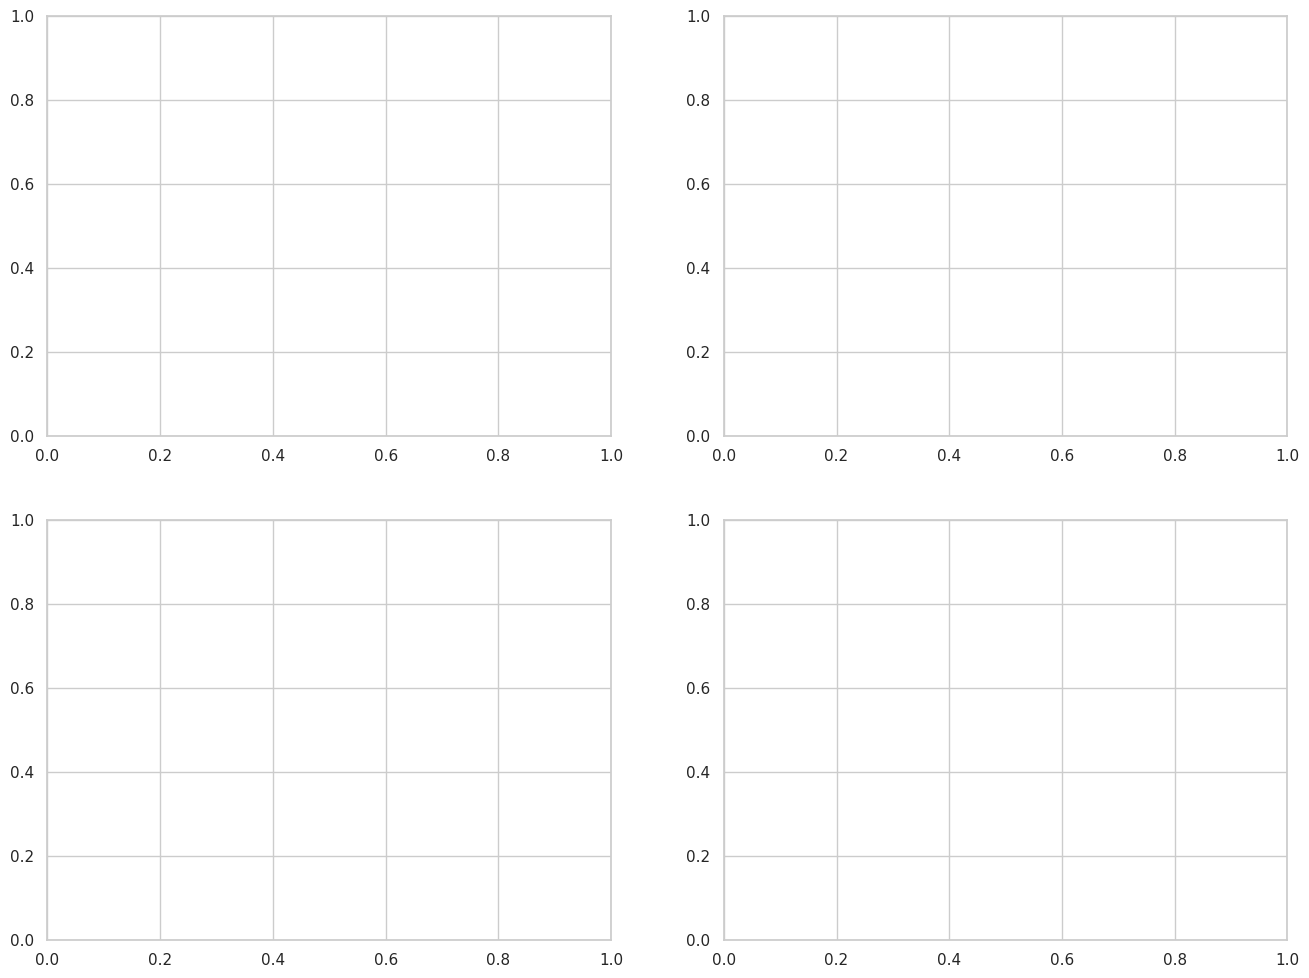

In [11]:
# Distribution of key metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.histplot(traffic_data['vehicle_count'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Vehicle Count Distribution')

sns.histplot(traffic_data['avg_speed'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Average Speed Distribution')

sns.histplot(traffic_data['occupancy_rate'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Occupancy Rate Distribution')

if 'travel_time' in traffic_data.columns:
    sns.histplot(traffic_data['travel_time'], kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('Travel Time Distribution')
elif 'queue_length' in traffic_data.columns:
    sns.histplot(traffic_data['queue_length'], kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('Queue Length Distribution')

plt.tight_layout()
plt.show()

In [ ]:
# Time series analysis of traffic metrics
if 'measurement_timestamp' in traffic_data.columns:
    # Extract date for grouping
    traffic_data['date'] = traffic_data['measurement_timestamp'].dt.date
    traffic_data['hour'] = traffic_data['measurement_timestamp'].dt.hour
    
    # Aggregate by hour for time series
    hourly_traffic = traffic_data.groupby('hour').agg({
        'vehicle_count': 'mean',
        'avg_speed': 'mean',
        'occupancy_rate': 'mean'
    }).reset_index()
    
    # Plot time series by hour
    fig, ax = plt.subplots(figsize=(14, 8))
    
    ax.plot(hourly_traffic['hour'], hourly_traffic['vehicle_count'], label='Vehicle Count')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Average Vehicle Count')
    ax.set_title('Average Vehicle Count by Hour of Day')
    ax.set_xticks(range(0, 24))
    plt.show()
    
    # Multi-metric analysis by hour
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)
    
    ax1.plot(hourly_traffic['hour'], hourly_traffic['avg_speed'], color='green')
    ax1.set_ylabel('Average Speed')
    ax1.set_title('Average Speed by Hour of Day')
    
    ax2.plot(hourly_traffic['hour'], hourly_traffic['occupancy_rate'], color='red')
    ax2.set_xlabel('Hour of Day')
    ax2.set_ylabel('Occupancy Rate')
    ax2.set_title('Average Occupancy Rate by Hour of Day')
    ax2.set_xticks(range(0, 24))
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Correlation analysis for traffic metrics
traffic_metrics = ['vehicle_count', 'avg_speed', 'occupancy_rate']

# Add other metrics if available
for col in ['queue_length', 'travel_time', 'delay_time', 'congestion_index']:
    if col in traffic_data.columns:
        traffic_metrics.append(col)

correlation_matrix = traffic_data[traffic_metrics].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Traffic Metrics')
plt.show()

In [ ]:
# Check for outliers using boxplots
plt.figure(figsize=(14, 8))
sns.boxplot(data=traffic_data[traffic_metrics])
plt.title('Boxplots for Traffic Metrics')
plt.xticks(rotation=45)
plt.show()

### Key Findings from Traffic Data Analysis:

1. **Vehicle count distribution** - [Your observations about the distribution]
2. **Speed distribution** - [Your observations about the distribution]
3. **Occupancy rate patterns** - [Your observations about patterns]
4. **Correlations between metrics** - [Your observations about correlations]
5. **Temporal patterns** - [Your observations about time patterns]
6. **Outliers** - [Your observations about outliers]

### Implications for Data Transformation:

1. [Transformation recommendation based on findings]
2. [Transformation recommendation based on findings]
3. [Transformation recommendation based on findings]

## 4. Location Dimension Analysis

Let's analyze the location dimension data to understand the geographical distribution of our traffic measurements.

In [ ]:
# Distribution of locations by district
if 'district' in location_data.columns:
    plt.figure(figsize=(12, 8))
    district_counts = location_data['district'].value_counts()
    sns.barplot(x=district_counts.index, y=district_counts.values)
    plt.title('Number of Locations by District')
    plt.xlabel('District')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# Distribution of road types
if 'road_type' in location_data.columns:
    plt.figure(figsize=(12, 6))
    road_type_counts = location_data['road_type'].value_counts()
    sns.barplot(x=road_type_counts.index, y=road_type_counts.values)
    plt.title('Distribution of Road Types')
    plt.xlabel('Road Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# Distribution of lanes and speed limits
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

if 'lanes' in location_data.columns:
    sns.countplot(x='lanes', data=location_data, ax=ax1)
    ax1.set_title('Distribution of Lane Counts')
    ax1.set_xlabel('Number of Lanes')
    ax1.set_ylabel('Count')

if 'speed_limit' in location_data.columns:
    sns.countplot(x='speed_limit', data=location_data, ax=ax2)
    ax2.set_title('Distribution of Speed Limits')
    ax2.set_xlabel('Speed Limit')
    ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
# Visualize geographical distribution if coordinates are available
if 'latitude' in location_data.columns and 'longitude' in location_data.columns:
    # Check for valid coordinates
    valid_coords = location_data.dropna(subset=['latitude', 'longitude'])
    
    if not valid_coords.empty:
        fig = px.scatter_mapbox(valid_coords, 
                               lat="latitude", 
                               lon="longitude", 
                               hover_name="intersection_id",
                               hover_data=["street_name", "district", "road_type"],
                               color="road_type" if "road_type" in valid_coords.columns else None,
                               size="lanes" if "lanes" in valid_coords.columns else None,
                               zoom=10,
                               height=600)
        fig.update_layout(mapbox_style="open-street-map")
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.show()

### Key Findings from Location Analysis:

1. **District distribution** - [Your observations about districts]
2. **Road type patterns** - [Your observations about road types]
3. **Lane configurations** - [Your observations about lanes]
4. **Speed limit distribution** - [Your observations about speed limits]
5. **Geographical patterns** - [Your observations about spatial distribution]

### Implications for Data Transformation:

1. [Transformation recommendation based on findings]
2. [Transformation recommendation based on findings]

## 5. Time Dimension Analysis

Let's analyze the temporal patterns in our traffic data.

In [ ]:
# Create time dimension from traffic data timestamps
if 'measurement_timestamp' in traffic_data.columns:
    time_dim = pd.DataFrame({
        'timestamp': pd.Series(traffic_data['measurement_timestamp'].unique()),
    })
    
    time_dim['hour'] = time_dim['timestamp'].dt.hour
    time_dim['day'] = time_dim['timestamp'].dt.day
    time_dim['day_of_week'] = time_dim['timestamp'].dt.dayofweek
    time_dim['day_name'] = time_dim['timestamp'].dt.day_name()
    time_dim['month'] = time_dim['timestamp'].dt.month
    time_dim['month_name'] = time_dim['timestamp'].dt.month_name()
    time_dim['year'] = time_dim['timestamp'].dt.year
    
    print(f"Time dimension created with {len(time_dim)} unique timestamps")
    time_dim.head()

In [ ]:
# Distribution of measurements by day of week
plt.figure(figsize=(12, 6))
day_counts = time_dim['day_name'].value_counts().reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
sns.barplot(x=day_counts.index, y=day_counts.values)
plt.title('Distribution of Measurements by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Distribution of measurements by hour of day
plt.figure(figsize=(14, 6))
hour_counts = time_dim['hour'].value_counts().sort_index()
sns.barplot(x=hour_counts.index, y=hour_counts.values)
plt.title('Distribution of Measurements by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.xticks(range(0, 24))
plt.show()

In [ ]:
# Hourly patterns by day of week (heatmap)
if 'measurement_timestamp' in traffic_data.columns:
    traffic_data['hour'] = traffic_data['measurement_timestamp'].dt.hour
    traffic_data['day_of_week'] = traffic_data['measurement_timestamp'].dt.dayofweek
    traffic_data['day_name'] = traffic_data['measurement_timestamp'].dt.day_name()
    
    # Create a pivot table for average vehicle count by day and hour
    hourly_by_day = traffic_data.pivot_table(
        values='vehicle_count', 
        index='hour', 
        columns='day_name',
        aggfunc='mean'
    ).reindex(columns=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
    
    # Create heatmap
    plt.figure(figsize=(14, 10))
    sns.heatmap(hourly_by_day, cmap="YlOrRd", annot=True, fmt=".0f")
    plt.title('Average Vehicle Count by Hour and Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Hour of Day')
    plt.show()

### Key Findings from Time Analysis:

1. **Daily patterns** - [Your observations about daily patterns]
2. **Hourly patterns** - [Your observations about hourly patterns]
3. **Weekly variations** - [Your observations about weekly variations]
4. **Peak times** - [Your observations about peak times]
5. **Time gaps** - [Your observations about any gaps in time coverage]

### Implications for Data Transformation:

1. [Transformation recommendation based on findings]
2. [Transformation recommendation based on findings]

## 6. Weather Dimension Analysis

Let's analyze the weather data to understand its impact on traffic patterns.

In [ ]:
# Convert timestamp to datetime if needed
if 'timestamp' in weather_data.columns and not pd.api.types.is_datetime64_any_dtype(weather_data['timestamp']):
    weather_data['timestamp'] = pd.to_datetime(weather_data['timestamp'])

In [ ]:
# Distribution of weather conditions
if 'condition' in weather_data.columns:
    plt.figure(figsize=(12, 6))
    condition_counts = weather_data['condition'].value_counts()
    sns.barplot(x=condition_counts.index, y=condition_counts.values)
    plt.title('Distribution of Weather Conditions')
    plt.xlabel('Weather Condition')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# Temperature distribution
if 'temperature' in weather_data.columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(weather_data['temperature'], bins=20, kde=True)
    plt.title('Temperature Distribution')
    plt.xlabel('Temperature')
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
# Weather impact on traffic
if 'timestamp' in weather_data.columns and 'measurement_timestamp' in traffic_data.columns:
    # Merge weather data with traffic data based on nearest timestamp
    # This is a simplified approach - in production, you'd use more sophisticated matching
    
    # Round timestamps to hour to make joining easier
    weather_data['hour_timestamp'] = weather_data['timestamp'].dt.floor('H')
    traffic_data['hour_timestamp'] = traffic_data['measurement_timestamp'].dt.floor('H')
    
    # Join datasets
    merged_data = pd.merge(traffic_data, weather_data, on='hour_timestamp', how='left')
    
    # Analyze traffic metrics by weather condition
    if 'condition' in merged_data.columns:
        plt.figure(figsize=(14, 8))
        sns.boxplot(x='condition', y='avg_speed', data=merged_data)
        plt.title('Impact of Weather Conditions on Average Speed')
        plt.xlabel('Weather Condition')
        plt.ylabel('Average Speed')
        plt.xticks(rotation=45)
        plt.show()
        
        plt.figure(figsize=(14, 8))
        sns.boxplot(x='condition', y='vehicle_count', data=merged_data)
        plt.title('Impact of Weather Conditions on Vehicle Count')
        plt.xlabel('Weather Condition')
        plt.ylabel('Vehicle Count')
        plt.xticks(rotation=45)
        plt.show()

In [ ]:
# Correlation between weather metrics and traffic metrics
if 'timestamp' in weather_data.columns and 'measurement_timestamp' in traffic_data.columns:
    # Use previously merged data
    
    # Select numeric columns for correlation analysis
    numeric_cols = merged_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Filter for relevant columns
    relevant_cols = [col for col in numeric_cols if col not in ['hour_timestamp', 'latitude', 'longitude']]
    
    # Calculate correlation matrix
    correlation_matrix = merged_data[relevant_cols].corr()
    
    # Focus on correlations between weather and traffic metrics
    weather_metrics = ['temperature', 'precipitation', 'visibility', 'wind_speed']
    weather_metrics = [col for col in weather_metrics if col in relevant_cols]
    
    traffic_metrics = ['vehicle_count', 'avg_speed', 'occupancy_rate', 'queue_length', 'travel_time']
    traffic_metrics = [col for col in traffic_metrics if col in relevant_cols]
    
    weather_traffic_corr = correlation_matrix.loc[weather_metrics, traffic_metrics]
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(weather_traffic_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation between Weather and Traffic Metrics')
    plt.show()

### Key Findings from Weather Analysis:

1. **Weather condition distribution** - [Your observations about weather conditions]
2. **Temperature patterns** - [Your observations about temperature patterns]
3. **Weather impact on traffic** - [Your observations about weather impact]
4. **Correlations** - [Your observations about correlations]

### Implications for Data Transformation:

1. [Transformation recommendation based on findings]
2. [Transformation recommendation based on findings]

## 7. Event Dimension Analysis

Let's analyze event data to understand how events impact traffic patterns.

In [ ]:
# Convert timestamps to datetime if needed
for col in ['start_time', 'end_time']:
    if col in event_data.columns and not pd.api.types.is_datetime64_any_dtype(event_data[col]):
        event_data[col] = pd.to_datetime(event_data[col])

In [ ]:
# Distribution of event types
if 'event_type' in event_data.columns:
    plt.figure(figsize=(12, 6))
    event_type_counts = event_data['event_type'].value_counts()
    sns.barplot(x=event_type_counts.index, y=event_type_counts.values)
    plt.title('Distribution of Event Types')
    plt.xlabel('Event Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# Event duration analysis
if 'start_time' in event_data.columns and 'end_time' in event_data.columns:
    # Calculate duration
    event_data['duration_hours'] = (event_data['end_time'] - event_data['start_time']).dt.total_seconds() / 3600
    
    plt.figure(figsize=(12, 6))
    sns.histplot(event_data['duration_hours'], bins=20, kde=True)
    plt.title('Distribution of Event Duration')
    plt.xlabel('Duration (hours)')
    plt.ylabel('Frequency')
    plt.show()
    
    # Event duration by type
    if 'event_type' in event_data.columns:
        plt.figure(figsize=(14, 8))
        sns.boxplot(x='event_type', y='duration_hours', data=event_data)
        plt.title('Event Duration by Type')
        plt.xlabel('Event Type')
        plt.ylabel('Duration (hours)')
        plt.xticks(rotation=45)
        plt.show()

In [ ]:
# Event impact on traffic
if 'start_time' in event_data.columns and 'measurement_timestamp' in traffic_data.columns:
    # Create a time window for each event (simplified approach)
    traffic_with_events = traffic_data.copy()
    traffic_with_events['has_event'] = False
    
    # For each event, mark traffic measurements that occurred during the event
    for _, event in event_data.iterrows():
        if pd.notna(event['start_time']) and pd.notna(event['end_time']):
            mask = (traffic_with_events['measurement_timestamp'] >= event['start_time']) & \
                   (traffic_with_events['measurement_timestamp'] <= event['end_time'])
            traffic_with_events.loc[mask, 'has_event'] = True
    
    # Compare traffic metrics with and without events
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='has_event', y='avg_speed', data=traffic_with_events)
    plt.title('Impact of Events on Average Speed')
    plt.xlabel('Event Occurring')
    plt.ylabel('Average Speed')
    plt.xticks([0, 1], ['No Event', 'Event Occurring'])
    plt.show()
    
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='has_event', y='vehicle_count', data=traffic_with_events)
    plt.title('Impact of Events on Vehicle Count')
    plt.xlabel('Event Occurring')
    plt.ylabel('Vehicle Count')
    plt.xticks([0, 1], ['No Event', 'Event Occurring'])
    plt.show()

### Key Findings from Event Analysis:

### Key Findings from Event Analysis:

1. **Event type distribution** - [Your observations about event types]
2. **Duration patterns** - [Your observations about event durations]
3. **Impact on traffic** - [Your observations about how events affect traffic]
4. **Temporal clustering** - [Your observations about when events tend to occur]

### Implications for Data Transformation:

1. [Transformation recommendation based on findings]
2. [Transformation recommendation based on findings]

## 8. Vehicle Dimension Analysis

Let's analyze the vehicle data to understand the distribution of vehicle types and their impact on traffic metrics.

In [ ]:
# Distribution of vehicle types
if 'vehicle_type' in vehicle_data.columns:
    plt.figure(figsize=(12, 6))
    vehicle_type_counts = vehicle_data['vehicle_type'].value_counts()
    sns.barplot(x=vehicle_type_counts.index, y=vehicle_type_counts.values)
    plt.title('Distribution of Vehicle Types')
    plt.xlabel('Vehicle Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# Distribution of vehicle classes
if 'vehicle_class' in vehicle_data.columns:
    plt.figure(figsize=(12, 6))
    vehicle_class_counts = vehicle_data['vehicle_class'].value_counts()
    sns.barplot(x=vehicle_class_counts.index, y=vehicle_class_counts.values)
    plt.title('Distribution of Vehicle Classes')
    plt.xlabel('Vehicle Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# Passenger capacity analysis
if 'passenger_capacity' in vehicle_data.columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(vehicle_data['passenger_capacity'], bins=10, kde=True)
    plt.title('Distribution of Passenger Capacity')
    plt.xlabel('Passenger Capacity')
    plt.ylabel('Frequency')
    plt.show()
    
    # Passenger capacity by vehicle type
    if 'vehicle_type' in vehicle_data.columns:
        plt.figure(figsize=(14, 8))
        sns.boxplot(x='vehicle_type', y='passenger_capacity', data=vehicle_data)
        plt.title('Passenger Capacity by Vehicle Type')
        plt.xlabel('Vehicle Type')
        plt.ylabel('Passenger Capacity')
        plt.xticks(rotation=45)
        plt.show()

### Key Findings from Vehicle Analysis:

1. **Vehicle type distribution** - [Your observations about vehicle types]
2. **Vehicle class patterns** - [Your observations about vehicle classes]
3. **Passenger capacity insights** - [Your observations about passenger capacity]

### Implications for Data Transformation:

1. [Transformation recommendation based on findings]
2. [Transformation recommendation based on findings]

## 9. Infrastructure Dimension Analysis

Let's analyze the infrastructure data to understand how infrastructure characteristics affect traffic patterns.

In [ ]:
# Convert date fields to datetime if needed
if 'last_maintenance_date' in infrastructure_data.columns and not pd.api.types.is_datetime64_any_dtype(infrastructure_data['last_maintenance_date']):
    infrastructure_data['last_maintenance_date'] = pd.to_datetime(infrastructure_data['last_maintenance_date'], errors='coerce')

In [ ]:
# Distribution of signal types
if 'signal_type' in infrastructure_data.columns:
    plt.figure(figsize=(12, 6))
    signal_type_counts = infrastructure_data['signal_type'].value_counts()
    sns.barplot(x=signal_type_counts.index, y=signal_type_counts.values)
    plt.title('Distribution of Signal Types')
    plt.xlabel('Signal Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# Distribution of road conditions
if 'road_condition' in infrastructure_data.columns:
    plt.figure(figsize=(12, 6))
    road_condition_counts = infrastructure_data['road_condition'].value_counts()
    sns.barplot(x=road_condition_counts.index, y=road_condition_counts.values)
    plt.title('Distribution of Road Conditions')
    plt.xlabel('Road Condition')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# Time since last maintenance
if 'last_maintenance_date' in infrastructure_data.columns:
    # Calculate days since maintenance
    infrastructure_data['days_since_maintenance'] = (pd.Timestamp.now() - infrastructure_data['last_maintenance_date']).dt.days
    
    plt.figure(figsize=(12, 6))
    sns.histplot(infrastructure_data['days_since_maintenance'].dropna(), bins=20, kde=True)
    plt.title('Distribution of Days Since Last Maintenance')
    plt.xlabel('Days')
    plt.ylabel('Frequency')
    plt.show()
    
    # Days since maintenance by road condition
    if 'road_condition' in infrastructure_data.columns:
        plt.figure(figsize=(14, 8))
        sns.boxplot(x='road_condition', y='days_since_maintenance', data=infrastructure_data)
        plt.title('Days Since Maintenance by Road Condition')
        plt.xlabel('Road Condition')
        plt.ylabel('Days Since Maintenance')
        plt.xticks(rotation=45)
        plt.show()

In [ ]:
# Capacity analysis
if 'capacity' in infrastructure_data.columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(infrastructure_data['capacity'], bins=10, kde=True)
    plt.title('Distribution of Infrastructure Capacity')
    plt.xlabel('Capacity')
    plt.ylabel('Frequency')
    plt.show()

### Key Findings from Infrastructure Analysis:

1. **Signal type distribution** - [Your observations about signal types]
2. **Road condition patterns** - [Your observations about road conditions]
3. **Maintenance insights** - [Your observations about maintenance patterns]
4. **Capacity insights** - [Your observations about capacity distribution]

### Implications for Data Transformation:

1. [Transformation recommendation based on findings]
2. [Transformation recommendation based on findings]

## 10. Relationships Between Dimensions

Let's explore how different dimensions interact with each other.

In [ ]:
# Join relevant dimensions to explore relationships
# This is a simplified approach - in production you'd need more sophisticated matching

# Join location and infrastructure data
if 'intersection_id' in location_data.columns and 'signal_type' in infrastructure_data.columns:
    # Assuming there's a common key between them
    # For this example, we'll use a random mapping for demonstration
    np.random.seed(42)  # For reproducibility
    location_data['signal_id'] = np.random.choice(infrastructure_data.index, size=len(location_data))
    infrastructure_data['infra_id'] = infrastructure_data.index
    
    location_infra = pd.merge(location_data, infrastructure_data, left_on='signal_id', right_on='infra_id', how='left')
    
    # Relationship between road type and signal type
    if 'road_type' in location_infra.columns and 'signal_type' in location_infra.columns:
        cross_tab = pd.crosstab(location_infra['road_type'], location_infra['signal_type'])
        plt.figure(figsize=(14, 10))
        sns.heatmap(cross_tab, annot=True, cmap='YlGnBu', fmt='d')
        plt.title('Road Type vs Signal Type')
        plt.ylabel('Road Type')
        plt.xlabel('Signal Type')
        plt.show()

In [ ]:
# Weather impact by location
# Assuming we have merged traffic and weather data from earlier analysis

try:
    # Check if merged_data exists from earlier weather analysis
    if 'merged_data' in locals() and 'district' in location_data.columns:
        # Add district information to merged data
        loc_mapping = {id_val: district for id_val, district in zip(location_data['intersection_id'], location_data['district'])}
        if 'location_id' in merged_data.columns:
            merged_data['district'] = merged_data['location_id'].map(loc_mapping)
            
            # Weather impact by district
            if 'condition' in merged_data.columns and 'district' in merged_data.columns and 'avg_speed' in merged_data.columns:
                plt.figure(figsize=(16, 10))
                sns.boxplot(x='district', y='avg_speed', hue='condition', data=merged_data)
                plt.title('Impact of Weather Conditions on Speed by District')
                plt.xlabel('District')
                plt.ylabel('Average Speed')
                plt.xticks(rotation=45)
                plt.legend(title='Weather Condition')
                plt.show()
except:
    print("Skipping weather by location analysis due to missing merged data")

In [ ]:
# Event impact by road type
try:
    # Check if traffic_with_events exists from earlier event analysis
    if 'traffic_with_events' in locals() and 'road_type' in location_data.columns:
        # Add road type information to traffic data
        loc_mapping = {id_val: r_type for id_val, r_type in zip(location_data['intersection_id'], location_data['road_type'])}
        if 'location_id' in traffic_with_events.columns:
            traffic_with_events['road_type'] = traffic_with_events['location_id'].map(loc_mapping)
            
            # Event impact by road type
            if 'has_event' in traffic_with_events.columns and 'road_type' in traffic_with_events.columns and 'avg_speed' in traffic_with_events.columns:
                plt.figure(figsize=(16, 10))
                sns.boxplot(x='road_type', y='avg_speed', hue='has_event', data=traffic_with_events)
                plt.title('Impact of Events on Speed by Road Type')
                plt.xlabel('Road Type')
                plt.ylabel('Average Speed')
                plt.xticks(rotation=45)
                plt.legend(title='Event Occurring', labels=['No', 'Yes'])
                plt.show()
except:
    print("Skipping event by road type analysis due to missing data")

### Key Findings from Dimension Relationships:

1. **Road type and signal type relationship** - [Your observations]
2. **Weather impact by location** - [Your observations]
3. **Event impact by road type** - [Your observations]

### Implications for Data Transformation:

1. [Transformation recommendation based on findings]
2. [Transformation recommendation based on findings]

## 11. Data Quality Assessment

Let's assess the quality of our data across all dimensions.

In [ ]:
# Function to assess data quality
def assess_data_quality(df, name):
    print(f"\n=== {name} Data Quality Assessment ===\n")
    
    # Check for missing values
    missing = df.isnull().sum()
    missing_pct = 100 * missing / len(df)
    missing_df = pd.DataFrame({'Missing Values': missing, 'Percentage': missing_pct})
    print("Missing Values:")
    print(missing_df[missing_df['Missing Values'] > 0])
    
    # Check for duplicates
    print(f"\nDuplicate rows: {df.duplicated().sum()} ({100*df.duplicated().sum()/len(df):.2f}%)")
    
    # Check for outliers in numeric columns
    print("\nPotential Outliers (values > 3 std devs from mean):")
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        mean = df[col].mean()
        std = df[col].std()
        outliers = df[(df[col] > mean + 3*std) | (df[col] < mean - 3*std)]
        if len(outliers) > 0:
            print(f"  {col}: {len(outliers)} potential outliers ({100*len(outliers)/len(df):.2f}%)")
    
    # Check for consistency issues
    print("\nValue Consistency Check:")
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    for col in categorical_cols:
        unique_values = df[col].nunique()
        if unique_values < 10:  # Only show for columns with few unique values
            print(f"  {col}: {unique_values} unique values - {df[col].value_counts().head(3).to_dict()}")
    
    print("\n" + "-"*50)

# Assess data quality for each dataset
assess_data_quality(traffic_data, "Traffic Measurements")
assess_data_quality(location_data, "Locations")
assess_data_quality(weather_data, "Weather")
assess_data_quality(event_data, "Events")
assess_data_quality(vehicle_data, "Vehicles")
assess_data_quality(infrastructure_data, "Infrastructure")

### Key Data Quality Issues and Recommendations:

1. **Missing Values**
   - [List specific columns with significant missing values]
   - Recommendation: [Fill with median/mode/interpolated values or drop if necessary]

2. **Duplicates**
   - [Note any tables with duplicates]
   - Recommendation: [Keep first occurrence or aggregate duplicate rows]

3. **Outliers**
   - [List specific columns with outliers]
   - Recommendation: [Capping, transformation, or removal approach]

4. **Consistency Issues**
   - [Note any inconsistent categorical variables]
   - Recommendation: [Standardization approach]

5. **Date/Time Issues**
   - [Note any issues with timestamps]
   - Recommendation: [Standardization approach]

6. **Referential Integrity**
   - [Note any relationship mismatches between fact and dimension tables]
   - Recommendation: [Approach to fix mismatches]

## 12. Transformation Recommendations

Based on our exploratory data analysis, here are the key data transformation recommendations for each dimension and fact table.

### Traffic Measurements (Fact Table) Transformations

1. **Handle Missing Values**
   - Fill missing vehicle counts with 0
   - Interpolate missing average speeds based on similar time periods
   - Set occupancy rate bounds between 0 and 1

2. **Handle Outliers**
   - Cap vehicle counts at [X value] (3σ from mean)
   - Cap average speeds at reasonable maximum (e.g., speed limit + 20%)
   - Remove measurements with invalid combinations (e.g., high speed + high occupancy)

3. **Derive Additional Metrics**
   - Calculate congestion index from speed, occupancy, and vehicle count
   - Estimate queue length where missing based on occupancy and speed
   - Calculate throughput rate from vehicle count and time interval

4. **Temporal Aggregation**
   - Create 5-minute, 15-minute, and hourly aggregations for faster analysis
   - Include min, max, avg, and std dev in aggregations

### Time Dimension Transformations

1. **Complete Time Hierarchy**
   - Add season (Spring, Summer, Fall, Winter) based on month
   - Add period of day (Morning, Afternoon, Evening, Night) based on hour
   - Add fiscal periods if relevant for reporting

2. **Special Period Flags**
   - Add weekend flag
   - Enhance holiday detection with a comprehensive holiday list
   - Add peak traffic indicator based on observed patterns

### Location Dimension Transformations

1. **Standardize Geographic Data**
   - Validate latitude/longitude values
   - Add missing coordinates using geocoding services
   - Create standardized district/zone names

2. **Enhance with Derived Attributes**
   - Add urban/suburban/rural classification
   - Create road classification groupings
   - Add proximity to key landmarks

### Weather Dimension Transformations

1. **Standardize Weather Conditions**
   - Map similar conditions to standard values (e.g., "Rain", "Drizzle" → "Rain")
   - Create weather severity classification

2. **Fill Temporal Gaps**
   - Interpolate weather for missing time periods
   - Create consistent hourly weather records

### Event Dimension Transformations

1. **Standardize Event Types**
   - Create hierarchical event categories
   - Standardize naming conventions

2. **Enhance with Derived Attributes**
   - Calculate expected impact score based on event size and type
   - Add event duration attributes (short, medium, long)

### Vehicle Dimension Transformations

1. **Standardize Vehicle Classifications**
   - Create consistent hierarchy of vehicle types
   - Map similar classes to standard values

2. **Derive Vehicle Attributes**
   - Add vehicle size categories based on passenger capacity
   - Add environmentally relevant classifications (electric, hybrid, gas)

### Infrastructure Dimension Transformations

1. **Standardize Infrastructure Types**
   - Create consistent signal type categories
   - Standardize road condition descriptions

2. **Derive Maintenance Metrics**
   - Calculate days since last maintenance
   - Create maintenance status category (recent, needed, overdue)

## Conclusion

This exploratory data analysis has provided valuable insights into our traffic flow data warehouse dimensions and facts. The findings will guide our ETL pipeline implementation and help us make informed decisions about data transformations.

Key takeaways:

1. **Data Quality**: [Summary of overall data quality]
2. **Traffic Patterns**: [Summary of important traffic patterns discovered]
3. **Dimensional Relationships**: [Summary of important relationships between dimensions]
4. **Transformation Priorities**: [List top transformation priorities]

Next steps in the ETL implementation:

1. Update the transformation logic based on these recommendations
2. Implement data quality checks in the pipeline
3. Create validation metrics to verify transformation success
4. Develop a monitoring framework for ongoing data quality assessment